In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing import sequence
from pathlib import Path
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Convolution1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from PIL import Image

In [2]:
usrp_path = "usrp_2"
B200_63_path = "B200_63"
B200_74_path = "B200_74"

In [3]:
usrp = np.fromfile(open(usrp_path),dtype=np.complex64)
B200_63 = np.fromfile(open(B200_63_path),dtype=np.complex64)
B200_74 = np.fromfile(open(B200_74_path),dtype=np.complex64)

In [ ]:
# print(usrp.shape)
# print(B200_63.shape)
# print(B200_74.shape)

In [4]:
usrp_real = [x.real for x in usrp]
B200_63_real = [x.real for x in B200_63]
B200_74_real =  [x.real for x in B200_74]

In [5]:
x = [i for i in range(1500000)]
y1 = usrp_real[:1500000]
y2 = B200_63_real[:1500000]
y3 = B200_74_real[:1500000]


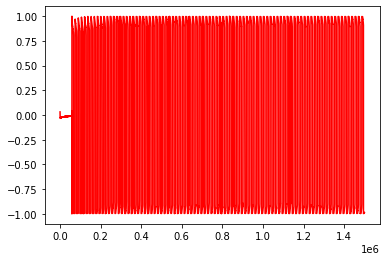

In [19]:
plt.plot(x,y1,color='red')
# plt.plot(x,y2,color = 'blue')
# plt.plot(x,y3,color = 'green')
plt.show()

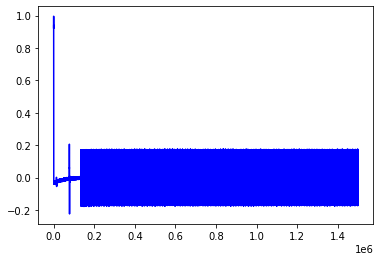

In [6]:
plt.plot(x,y2,color = 'blue')
plt.show()

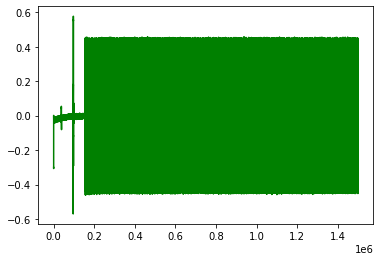

In [7]:
plt.plot(x,y3,color = 'green')
plt.show()

In [8]:
samples = 200
points_per_sample = 1024
offset = 204800

In [13]:
usrp_train = []
B200_63_train = []
B200_74_train = []
y_train = []
for n in range(samples):
    B200_63_train.append(B200_63_real[n*points_per_sample + offset:n*points_per_sample+points_per_sample + offset])
    y_train.append([1,0])

for n in range(samples):
    B200_74_train.append(B200_74_real[n*points_per_sample + offset:n*points_per_sample+points_per_sample + offset])
    y_train.append([0,1])


    
B200_63_train = np.array(B200_63_train)
B200_63_train = (B200_63_train - B200_63_train.min()) / (B200_63_train.max() - B200_63_train.min())   
B200_74_train = np.array(B200_74_train)
B200_74_train = (B200_74_train - B200_74_train.min()) / (B200_74_train.max() - B200_74_train.min())   
y_train = np.array(y_train)
    
print(B200_63_train.shape)
print(B200_74_train.shape)
print(y_train.shape)
    

(200, 1024)
(200, 1024)
(400, 2)


In [14]:
x_train = np.append(B200_63_train, B200_74_train, 0)
x_train = x_train.reshape(2*samples,points_per_sample,1)
permutation = np.random.permutation(len(x_train))
x_train = x_train[permutation]
y_train = y_train[permutation]
print(x_train.shape)
print(y_train.shape)

(400, 1024, 1)
(400, 2)


In [11]:
# x_train = (x_train - x_train.min()) / (x_train.max() - x_train.min())   

In [15]:
def OneD_CNN():
    model = Sequential()
    model.add(Convolution1D(filters = 64, kernel_size=3,strides=3,input_shape=(points_per_sample,1)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3))
    model.add(Convolution1D(filters = 128, kernel_size=3,strides=1))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    return model

In [16]:
oned_CNN = OneD_CNN()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
oned_CNN.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])  
oned_CNN.summary()

2022-08-10 14:57:23.435389: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 341, 64)           256       
                                                                 
 activation (Activation)     (None, 341, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 113, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 111, 128)          24704     
                                                                 
 activation_1 (Activation)   (None, 111, 128)          0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 37, 128)          0         
 1D)                                                    

In [17]:
oned_CNN_hist = oned_CNN.fit(x_train,y_train,batch_size=16,epochs= 150,validation_split=0.2,shuffle= True)

Epoch 1/150
20/20 [==============================] - 1s 17ms/step - loss: 0.7670 - accuracy: 0.4938 - val_loss: 0.6937 - val_accuracy: 0.5125
Epoch 2/150
20/20 [==============================] - 0s 9ms/step - loss: 0.6938 - accuracy: 0.5063 - val_loss: 0.6945 - val_accuracy: 0.4625
Epoch 3/150
20/20 [==============================] - 0s 9ms/step - loss: 0.6957 - accuracy: 0.5094 - val_loss: 0.6969 - val_accuracy: 0.4625
Epoch 4/150
20/20 [==============================] - 0s 9ms/step - loss: 0.6934 - accuracy: 0.5094 - val_loss: 0.6951 - val_accuracy: 0.4625
Epoch 5/150
20/20 [==============================] - 0s 9ms/step - loss: 0.6947 - accuracy: 0.4719 - val_loss: 0.6916 - val_accuracy: 0.5375
Epoch 6/150
20/20 [==============================] - 0s 9ms/step - loss: 0.6931 - accuracy: 0.4906 - val_loss: 0.6938 - val_accuracy: 0.4625
Epoch 7/150
20/20 [==============================] - 0s 9ms/step - loss: 0.6952 - accuracy: 0.5094 - val_loss: 0.6968 - val_accuracy: 0.4625
Epoch 8/150


In [18]:
oned_CNN.save("B_B")
# oned_CNN.save_weights("weights.model")

INFO:tensorflow:Assets written to: B_B/assets


INFO:tensorflow:Assets written to: B_B/assets


In [ ]:
# loaded = tf.keras.models.load_model("N_B")


In [ ]:
# loaded.summary()

In [ ]:
# test = usrp_real[201*1024 + 204800:202*1024+204800]
# test = usrp_real[2]
# test = np.array(test)
# test = (test - test.min()) / (test.max() - test.min()) 
# print(test.shape)  

In [ ]:
# prediction = loaded.predict(test)
# print(prediction)

In [ ]:
# oned_CNN2 = OneD_CNN()
# oned_CNN2.load_weights("weights.model")

In [ ]:
# oned_CNN2.predict(x_train[3].reshape(1,1024,1))